### First thing check wether we launched with CPU or GPU

In [1]:
import gpu_check
t = gpu_check.test()

[Elemwise{exp,no_inplace}(<TensorType(float64, vector)>)]
Looping 1000 times took 4.417225 seconds
Result is [ 1.23178032  1.61879341  1.52278065 ...,  2.20771815  2.29967753
  1.62323285]
Used the cpu


In [2]:
from os import listdir
from os.path import isfile, join
import dicom
import pylab
import numpy as np

In [3]:
# defines a utilit function to display array as image
import PIL.Image
from cStringIO import StringIO
import IPython.display
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [4]:
# imports from : https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial/discussion
%matplotlib inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [5]:
# file copied from FastAI mooc
import utils
#import vgg16
from vgg16 import Vgg16
#
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Using Theano backend.


In [6]:
import pandas
labels = pandas.read_csv("../dicom/stage1_labels.csv")
labels.head(5)

,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1


In [7]:
patients = [pn for pn in listdir("../dicom/") if len(pn) and pn.find('.')<0]

In [8]:
len(patients)

20

In [9]:
patientname = patients[2]

In [10]:
labels[labels.id==patientname].iloc[0].cancer

1

In [11]:
dicompath = "../dicom/" + patientname
dicomfiles = [f for f in listdir(dicompath) if isfile(join(dicompath, f)) and f.endswith(".dcm")]

In [12]:
print(len(dicomfiles))

123


In [13]:
ds = dicom.read_file(dicompath+"/"+dicomfiles[0])

In [14]:
assert(ds.PatientName == patientname)

In [15]:
# Order the slices (one slide per dicom file) by SliceLocation
def compareBy1(x, y):
    delta = x[1] - y[1]
    if delta == 0:
        return 0
    if delta < 0:
        return -1
    else:
        return 1
L = [(dcmf, float(dicom.read_file(dicompath+"/"+dcmf).SliceLocation)) for dcmf in dicomfiles]
orderedL = sorted(L, cmp=compareBy1)
orderedL[0:10]

[('170e5740c1016d961aa190ca599b4e4f.dcm', -309.519989),
 ('dd0ac71e58908570d9ad3d15260d5c7e.dcm', -307.019989),
 ('e1909590f30a0747e45f6583327e7663.dcm', -304.519989),
 ('73f84fe34af59e18bde59dc8b23d255b.dcm', -302.019989),
 ('49ccba51bcd61d6c3e6d5d4897395164.dcm', -299.519989),
 ('6043524d826fa4bbe4f9b5521fd4e499.dcm', -297.019989),
 ('80b8a59247fdfe80233944ab3703ec0d.dcm', -294.519989),
 ('03e3efcd298d53d597c497e00a05254e.dcm', -292.019989),
 ('9ca59a8ba93c5a7051eaf9cfa2937e66.dcm', -289.519989),
 ('81b2a4748125102890bf6cb0ad509b36.dcm', -287.019989)]

In [16]:
DSs = [dicom.read_file(dicompath+"/"+f_sl[0]) for f_sl in orderedL]

In [17]:
DSs[0].pixel_array.shape

(512, 512)

### Raw data plot : pixel values needs transformation

In [18]:
DSs[0].pixel_array.min(), DSs[0].pixel_array.max() # check "pixel" data scale

(-2000, 2329)

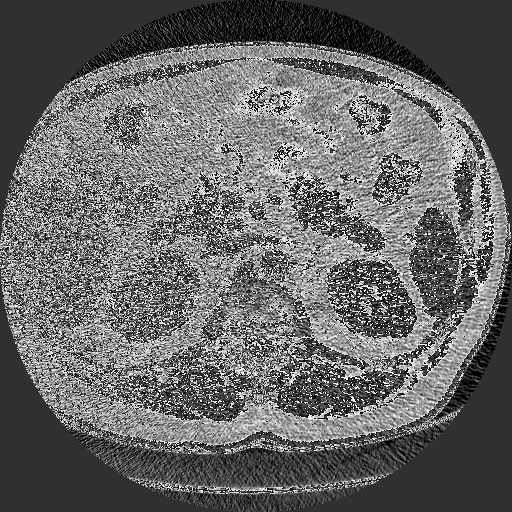

In [19]:
showarray(DSs[0].pixel_array)

## PreProcessing
Follow this great tutorial :

https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial/discussion

In [20]:
slices = DSs
slices.sort(key = lambda x: int(x.ImagePositionPatient[2])) # WARNING : I did another sorting
try:
    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
except:
    slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    
for s in slices:
    s.SliceThickness = slice_thickness

In [21]:
slice_thickness

2.5

### Hounsfield Unit (HU)

The unit of measurement in CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.


See wikipedia


By default however, the returned values are not in this unit. Let's fix this.


Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

In [22]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [ ]:
first_patient = slices
first_patient_pixels = get_pixels_hu(first_patient)

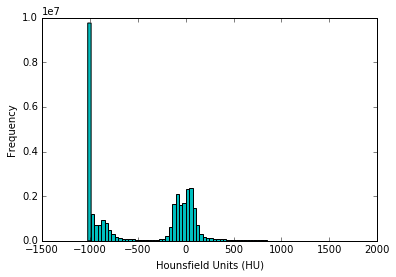

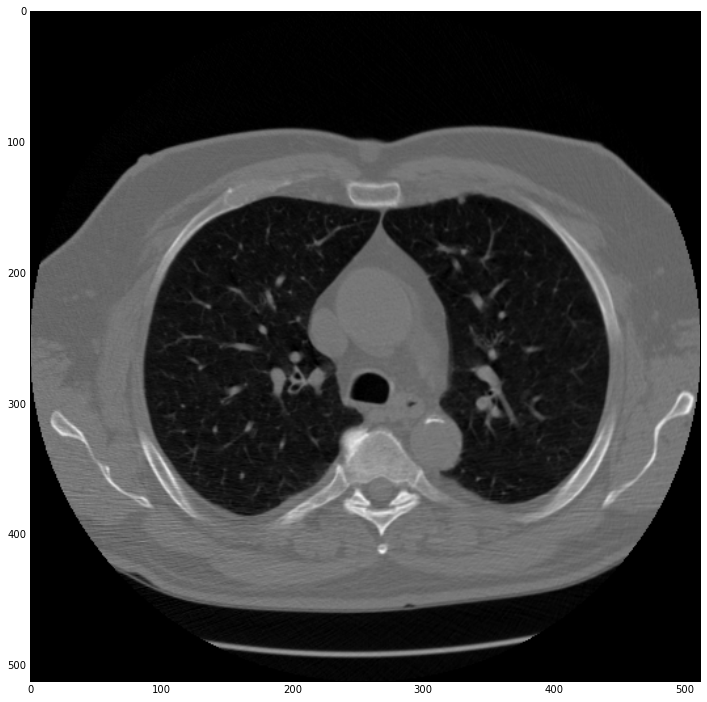

In [202]:
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
fig = plt.figure(figsize=(12,12))
plt.imshow(first_patient_pixels[84], cmap=plt.cm.gray)
plt.show()

### Resampling
A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)!
A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance.
Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while.
Below code worked well for us (and deals with the edge cases):

In [53]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

Please note that when you apply this, to save the new spacing! Due to rounding this may be slightly off from the desired spacing (above script picks the best possible spacing with rounding).
Let's resample our patient's pixels to an isomorphic resolution of 1 by 1 by 1 mm.

In [54]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

('Shape before resampling\t', (123, 512, 512))
('Shape after resampling\t', (308, 355, 355))


## 3D plotting the scan : VERY VERY SLOW
For visualization it is useful to be able to show a 3D image of the scan. Unfortunately, the packages available in this Kaggle docker image is very limited in this sense, so we will use marching cubes to create an approximate mesh for our 3D object, and plot this with matplotlib. Quite slow and ugly, but the best we can do.

In [55]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

**WARNING : 3D plot is very slow**

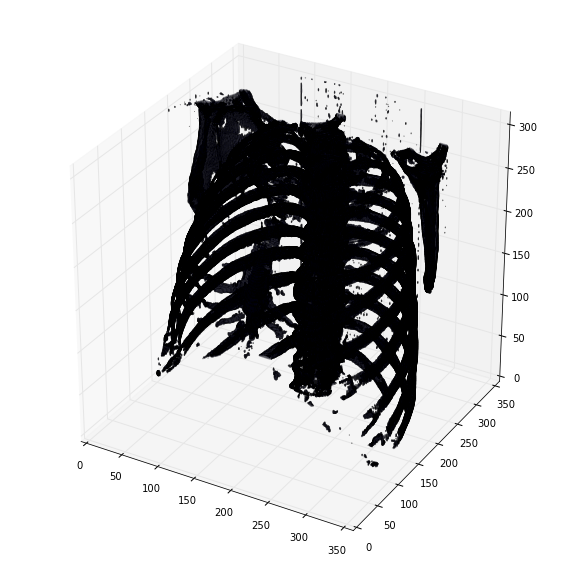

In [56]:
plot_3d(pix_resampled, 400)

## Lung Segmentation
In order to reduce the problem space, we can segment the lungs (and usually some tissue around it). The method that me and my student colleagues developed was quite effective.
It involves quite a few smart steps. It consists of a series of applications of region growing and morphological operations. In this case, we will use only connected component analysis.
The steps:
Threshold the image (-320 HU is a good threshold, but it doesn't matter much for this approach)
Do connected components, determine label of air around person, fill this with 1s in the binary image
Optionally: For every axial slice in the scan, determine the largest solid connected component (the body+air around the person), and set others to 0. This fills the structures in the lungs in the mask.
Keep only the largest air pocket (the human body has other pockets of air here and there).

In [58]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [59]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

In [61]:
#plot_3d(segmented_lungs, 0) # WARNING : currently fails

But there's one thing we can fix, it is probably a good idea to include structures within the lung (as the nodules are solid), we do not only want to air in the lungs.

In [29]:
#plot_3d(segmented_lungs_fill, 0) # WARNING : currently fails

That's better. Let's also visualize the difference between the two.

In [30]:
#plot_3d(segmented_lungs_fill - segmented_lungs, 0) # WARNING : currently fails

Anyway, when you want to use this mask, remember to first apply a dilation morphological operation on it (i.e. with a circular kernel). This expands the mask in all directions. The air + structures in the lung alone will not contain all nodules, in particular it will miss those that are stuck to the side of the lung, where they often appear! So expand the mask a little :)
This segmentation may fail for some edge cases. It relies on the fact that the air outside the patient is not connected to the air in the lungs. If the patient has a tracheostomy, this will not be the case, I do not know whether this is present in the dataset. Also, particulary noisy images (for instance due to a pacemaker in the image below) this method may also fail. Instead, the second largest air pocket in the body will be segmented. You can recognize this by checking the fraction of image that the mask corresponds to, which will be very small for this case. You can then first apply a morphological closing operation with a kernel a few mm in size to close these holes, after which it should work (or more simply, do not use the mask for this image).

### Normalization
Our values currently range from -1024 to around 2000. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity. A commonly used set of thresholds in the LUNA16 competition to normalize between are -1000 and 400. Here's some code you can use:

In [31]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

### Zero centering
As a final preprocessing step, it is advisory to zero center your data so that your mean value is 0. To do this you simply subtract the mean pixel value from all pixels.
To determine this mean you simply average all images in the whole dataset. If that sounds like a lot of work, we found this to be around 0.25 in the LUNA16 competition.
Warning: Do not zero center with the mean per image (like is done in some kernels on here). The CT scanners are calibrated to return accurate HU measurements. There is no such thing as an image with lower contrast or brightness like in normal pictures.

In [32]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

### What's next?
With these steps your images are ready for consumption by your CNN or other ML method :). You can do all these steps offline (one time and save the result), and I would advise you to do so and let it run overnight as it may take a long time.
### IMPORTANT TIP
To save storage space, don't do normalization and zero centering beforehand, but do this online (during training, just after loading). If you don't do this yet, your image are int16's, which are smaller than float32s and easier to compress as well.

## Deep Learning model
#### Following FastAI course we derive it from pre-trained ImageNet winner 

In [49]:
vgg = Vgg16()
#model = vgg.model # avoid this alias

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [73]:
# run dummy prediction on a CT slice image
# WARNING : data need to be turned into fake colour
gs = first_patient_pixels[50,100:324,100:324] # grey scale 224*224 image patch
rgbb = np.array([[gs,gs,gs],]) # fake RGB colour version as 1-element batch
rgbb255 = (rgbb.astype(float) - rgbb.min()) * 254 / (rgbb.max()-rgbb.min()) # scale from 0 to 255
vgg.predict(rgbb255.astype(int)) # predict input expected to have shape (None, 3, 224, 224)

(array([ 0.0483], dtype=float32), array([714]), [u'pick'])

In [47]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [27]:
# remove top softmax layer as we dont need the 1000 image classification
vgg.model.pop()
# fix the remaining layers as they are
for layer in vgg.model.layers:
    layer.trainable=False
# add a 2 category softmax classification for cancer / no-cancer
vgg.model.add(Dense(2, activation='softmax'))
# if you want to see the change run again "vgg.model.summary()"

In [28]:
opt = RMSprop(lr=0.1)
vgg.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
# outline of what is left to do :
#   creating iterator on batches
#   fitting the model
#   evaluating
# WARNING : In our case we have CT data "pixel" array, not image files
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=5, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=5)

#batches
'''
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

fit_model(model, batches, val_batches, nb_epoch=2)
#model.save_weights(model_path+'finetune1.h5')
model.evaluate(val_data, val_labels)
'''

"\ngen=image.ImageDataGenerator()\nbatches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)\nval_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)\n\nfit_model(model, batches, val_batches, nb_epoch=2)\n#model.save_weights(model_path+'finetune1.h5')\nmodel.evaluate(val_data, val_labels)\n"

In [44]:
def getSliceAsImage(i):
    gs = first_patient_pixels[i,120:344,120:344] # grey scale 224*224 image patch
    rgbb = np.array([[gs,gs,gs],]) # fake RGB colour version as 1-element batch
    rgbb255 = (rgbb.astype(float) - rgbb.min()) * 254 / (rgbb.max()-rgbb.min()) # scale from 0 to 255
    return rgbb255.astype(int)

In [69]:
L = [getSliceAsImage(i) for i in range(10)]

In [70]:
#I = iter(L)
#fit_model(vgg.model, I, I, nb_epoch=2)

In [71]:
batch = np.concatenate(L, axis=0)
vgg.model.train_on_batch(batch, [[0,1] for i in range(10)], sample_weight=None, class_weight=None)

[array(1.6542457342147827, dtype=float32),
 array(0.4000000059604645, dtype=float32)]

### Intermediate feature

In [225]:
get_feature = K.function([vgg.model.layers[0].input],
                         [vgg.model.layers[6].output,
                          vgg.model.layers[8].output,
                          vgg.model.layers[10].output,]
                        )

In [226]:
im = getSliceAsImage(84)
feat = get_feature([im])
print(len(feat))
print(feat[0].shape)

3
(1, 64, 114, 114)


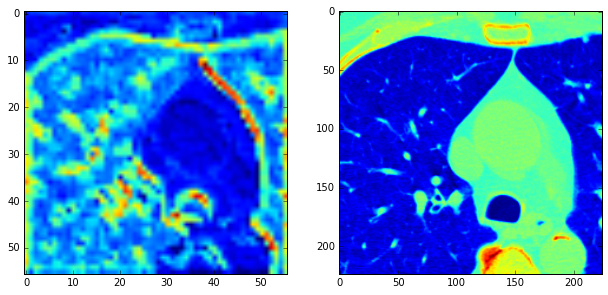

In [229]:
fig = plt.figure(figsize=(16,16))
fig.add_subplot(3, 1, 1)
plt.imshow(im[0,0,:,:])
fig.add_subplot(3, 3, 1)
plt.imshow(feat[2][0,0,:,:])
plt.show()